In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Setup paths to our data directories
train_dir = r"C:\Users\SAJJAD-PC\Downloads\Major_Project\Image_data\train"
test_dir = r"C:\Users\SAJJAD-PC\Downloads\Major_Project\Image_data\test"

In [3]:
# Define data augmentation parameters
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [4]:
# Import data from directories and apply augmentation
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224))

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224))

Found 144 images belonging to 3 classes.
Found 35 images belonging to 3 classes.


In [5]:
# MobileNetV2 URL
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [6]:
# Function to create model using MobileNetV2
def create_mobilenet_model(model_url, num_classes=3):
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name="MobileNetV2_model",
                                             input_shape=IMAGE_SHAPE + (3,))
    
    # Create our image model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dropout(0.5), 
        layers.Dense(128,"relu"),
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    return model

In [7]:
# Create MobileNetV2 model
mobilenet_model = create_mobilenet_model(mobilenet_url, num_classes=3)

In [8]:
# Compile the model
mobilenet_model.compile(loss="categorical_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                         metrics=["accuracy"])

In [9]:
# Print model summary
mobilenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobileNetV2_model (KerasLay  (None, 1280)             2257984   
 er)                                                             
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# Fit the model
mobilenet_history = mobilenet_model.fit(train_data,
                                         epochs=15,
                                         validation_data=valid_data)

Epoch 1/15
5/5 [==============================] - 6s 1s/step - loss: 0.1782 - accuracy: 0.9167 - val_loss: 0.5052 - val_accuracy: 0.8000
Epoch 2/15
5/5 [==============================] - 6s 1s/step - loss: 0.1188 - accuracy: 0.9722 - val_loss: 0.6362 - val_accuracy: 0.6857
Epoch 3/15
5/5 [==============================] - 5s 1s/step - loss: 0.1087 - accuracy: 0.9583 - val_loss: 0.5706 - val_accuracy: 0.9143
Epoch 4/15
5/5 [==============================] - 5s 1s/step - loss: 0.1430 - accuracy: 0.9792 - val_loss: 0.6050 - val_accuracy: 0.7143
Epoch 5/15
5/5 [==============================] - 6s 1s/step - loss: 0.0992 - accuracy: 0.9653 - val_loss: 0.5114 - val_accuracy: 0.8000
Epoch 6/15
5/5 [==============================] - 6s 1s/step - loss: 0.0831 - accuracy: 0.9722 - val_loss: 0.5259 - val_accuracy: 0.8286
Epoch 7/15
5/5 [==============================] - 6s 1s/step - loss: 0.0703 - accuracy: 0.9792 - val_loss: 0.5942 - val_accuracy: 0.7143
Epoch 8/15
5/5 [=========================

In [14]:
# Evaluate the model on the validation data
scores = mobilenet_model.evaluate(valid_data, verbose=0)
average_accuracy = scores[1]

print("Average Accuracy:", average_accuracy)

Average Accuracy: 0.8571428656578064


In [11]:
# Save the model
mobilenet_model.save('saved_model/mobilenet_model')

# Load the saved model
mobilenet_model = tf.keras.models.load_model('saved_model/mobilenet_model')


INFO:tensorflow:Assets written to: saved_model/mobilenet_model\assets


INFO:tensorflow:Assets written to: saved_model/mobilenet_model\assets


In [19]:
# Function to import an image and preprocess it
def load_and_prep_image(filename, img_shape=224):
    "Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3)."
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    # Normalize pixel values to [0, 1]
    img = img / 255.
    return img

In [20]:
# Function to make prediction using a model, plot the image with predicted class, and display prediction probabilities
def pred_and_plot(model, filename, class_names):
    # Load and preprocess the image
    img = load_and_prep_image(filename)
    
    # Make prediction using the model
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    # Determine predicted class based on model output
    pred_class = class_names[tf.argmax(pred[0])]

    
    # Print prediction probabilities
    print('Prediction Probabilities:', pred[0])

    # Plot the image with predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)


1/1 [==============================] - 0s 86ms/step
Prediction Probabilities: [5.569222e-03 3.638121e-08 9.944307e-01]


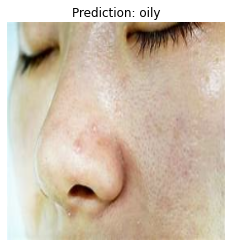

In [23]:
# Make a prediction using MobileNetV2 model
pred_and_plot(model=mobilenet_model,
              filename="oily53.jpeg",
              class_names=np.array(['dry', 'normal', 'oily']))